In [1]:
import tensorflow as tf
import os
import splitfolders as sf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, roc_auc_score
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, concatenate, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
def delete_files_with_letters(directory):
    # Initialize the counter
    deleted_count = 0
    
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file name contains 'd', 's', or 'h'
            if any(char.lower() in file.lower() for char in ['d', 's', 'h']):
                file_path = os.path.join(root, file)
                # Delete the file
                
                os.remove(file_path)
                deleted_count += 1
    
    # Display the number of deleted files
    print("\nNumber of deleted files:", deleted_count)

In [6]:
start_dir = r'A:\AI DB\LSPD\images_pret'
    
print("Deleting files containing 'd', 's', or 'h' from directory:", start_dir)
delete_files_with_letters(start_dir)

Deleting files containing 'd', 's', or 'h' from directory: A:\AI DB\LSPD\images_pret

Number of deleted files: 0


In [7]:
train_dir = r'A:\AI DB\LSPD\images_pret\train'
validation_dir = r'A:\AI DB\LSPD\images_pret\val'
test_dir = r'A:\AI DB\LSPD\images_pret\test'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 128

In [9]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5] 
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 315000 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [15]:
input_layer2 = tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_layer')
# Instantiate the MobileNetV3 model
mobilenetv3 = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)
output_mobilenetv3 = mobilenetv3(input_layer2)

# Instantiate the DenseNet169 model
densenet169 = tf.keras.applications.DenseNet169(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)
output_densenet169 = densenet169(input_layer2)

inceptionv3 = tf.keras.applications.InceptionV3(
                        include_top = False, 
                        weights = 'imagenet',
                        input_shape = (img_height, img_width,3),
                        pooling = 'avg', 
                    )
output_inceptionv3 = inceptionv3(input_layer2)

# Rename layers
for layer in mobilenetv3.layers:
    layer.trainable = False
for layer in densenet169.layers:
    layer.trainable = False
for layer in inceptionv3.layers:
    layer.trainable = False    

# Concatenate the outputs of the two pretrained models
combined_features = tf.keras.layers.Concatenate(name='concatenate')([
    output_mobilenetv3,
    output_densenet169,
    output_inceptionv3
])

# Add additional layers
x = tf.keras.layers.Flatten(name='flatten')(combined_features)
x = tf.keras.layers.Dense(1024, activation='relu', name='dense')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Create the combined model
combined_model = tf.keras.Model(inputs=input_layer2, outputs=output_layer)


In [16]:
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_layer[0][0]']      

In [18]:
checkpoint_path = r'A:\AI DB\LSPD\models\3modals.keras'

In [25]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Define the file path for the checkpoint
checkpoint_path = r'A:\AI DB\LSPD\models\3Modal.keras'

# Calculate the number of warm-up epochs (5% of total epochs)
total_epochs = 12  # Assuming you have 20 epochs in total
warmup_epochs = int(0.05 * total_epochs)

# Define your custom learning rate scheduler with warm-up
def lr_schedule(epoch, lr):
    if epoch < warmup_epochs:
        # Warm-up: gradually increase the learning rate
        return (epoch + 1) * (0.001 / warmup_epochs)  # Linear warm-up from 0.001
    elif epoch < warmup_epochs + 2:
        return 0.001  # Initial learning rate
    elif epoch < warmup_epochs + 4:
        return 0.0005
    elif epoch < warmup_epochs + 10:
        return 0.0001
    else:
        return 0.00001

# Create callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

In [26]:
# Train the model with callbacks and class weights
history = combined_model.fit(train_generator, 
                             epochs=total_epochs, 
                             validation_data=validation_generator, 
                             callbacks=[checkpoint, early_stopping, lr_scheduler], 
                             class_weight=class_weights_dict)

Epoch 1/12
2461/2461 [==============================] - 6994s 3s/step - loss: 0.1006 - accuracy: 0.9647 - val_loss: 0.0655 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 2/12
2461/2461 [==============================] - 6976s 3s/step - loss: 0.0890 - accuracy: 0.9689 - val_loss: 0.0640 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 3/12
2461/2461 [==============================] - 7007s 3s/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.0549 - val_accuracy: 0.9806 - lr: 5.0000e-04
Epoch 4/12
2461/2461 [==============================] - 6993s 3s/step - loss: 0.0779 - accuracy: 0.9730 - val_loss: 0.0548 - val_accuracy: 0.9807 - lr: 5.0000e-04
Epoch 5/12
2461/2461 [==============================] - 6983s 3s/step - loss: 0.0729 - accuracy: 0.9748 - val_loss: 0.0528 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 6/12
2461/2461 [==============================] - 6973s 3s/step - loss: 0.0723 - accuracy: 0.9752 - val_loss: 0.0525 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 7/12
2461/2461 [========

In [27]:
# Predict on the test set
ypred = combined_model.predict(test_generator)

157/157 [==============================] - 317s 2s/step


Accuracy Score: 0.9824
F1 Score: 0.9824
Classification Report:
               precision    recall  f1-score   support

           0     0.9836    0.9812    0.9824     10000
           1     0.9812    0.9836    0.9824     10000

    accuracy                         0.9824     20000
   macro avg     0.9824    0.9824    0.9824     20000
weighted avg     0.9824    0.9824    0.9824     20000



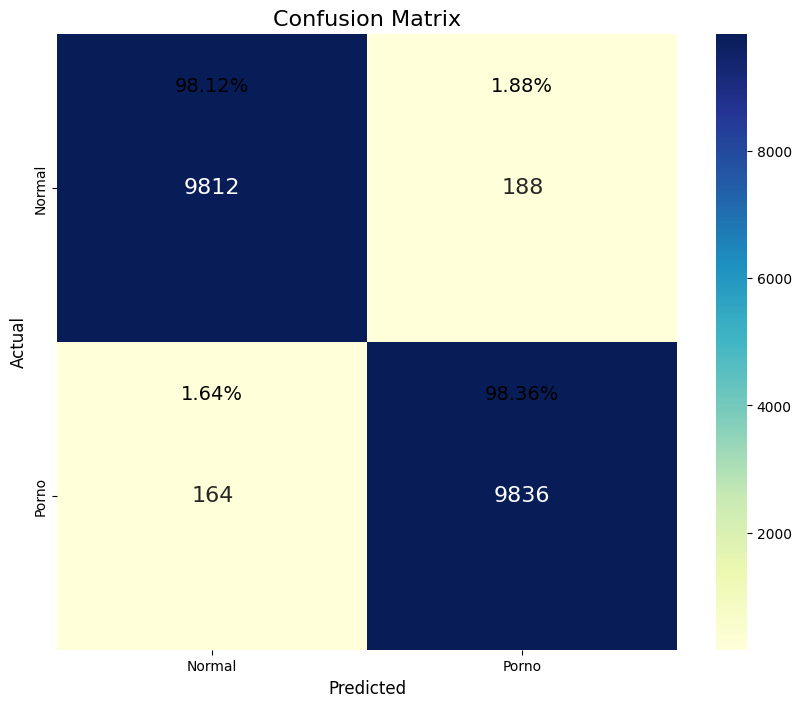

In [28]:
# Convert predicted probabilities to binary predictions
y_pred_classes = (ypred >  0.5).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes,digits=4)
print("Classification Report:\n", cr)

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



In [29]:
from sklearn.metrics import accuracy_score, f1_score

ypred_prob=ypred
# Define a list of threshold values to test
threshold_values = np.arange(0.01, 1.0, 0.01)

# Initialize lists to store evaluation metrics
accuracy_scores = []

f1_scores = []

# Iterate through each threshold value
for threshold in threshold_values:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_classes = (ypred_prob > threshold).astype(int)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    accuracy_scores.append(accuracy)
    
    # Calculate F1 score
    f1 = f1_score(y_true_classes, y_pred_classes)
    f1_scores.append(f1)

# Find the index of the threshold with the highest accuracy score
best_accuracy_index = np.argmax(accuracy_scores)
best_accuracy_threshold = threshold_values[best_accuracy_index]
best_accuracy = accuracy_scores[best_accuracy_index]

# Find the index of the threshold with the highest F1 score
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = threshold_values[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print("Best Accuracy:")
print("Threshold:", best_accuracy_threshold)
print("Accuracy Score:", best_accuracy)

print("\nBest F1 Score:")
print("Threshold:", best_f1_threshold)
print("F1 Score:", best_f1)


Best Accuracy:
Threshold: 0.5
Accuracy Score: 0.9824

Best F1 Score:
Threshold: 0.5
F1 Score: 0.9824210946863764


In [30]:
nudenet_test_dir = r'A:\AI DB\NudeNet\Nouveau dossier'

In [35]:
nudenet_test_datagen = ImageDataGenerator(rescale=1./255)
nudenet_test_generator = nudenet_test_datagen.flow_from_directory(
    nudenet_test_dir,
    target_size=(224, 224),
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 7928 images belonging to 2 classes.


In [36]:
yprednudenet = combined_model.predict(nudenet_test_generator)

248/248 [==============================] - 39s 155ms/step


Classification Report:
               precision    recall  f1-score   support

           0     0.8480    0.8390    0.8435      4050
           1     0.8337    0.8430    0.8383      3878

    accuracy                         0.8409      7928
   macro avg     0.8409    0.8410    0.8409      7928
weighted avg     0.8410    0.8409    0.8410      7928

Accuracy Score: 0.8409
F1 Score: 0.8383


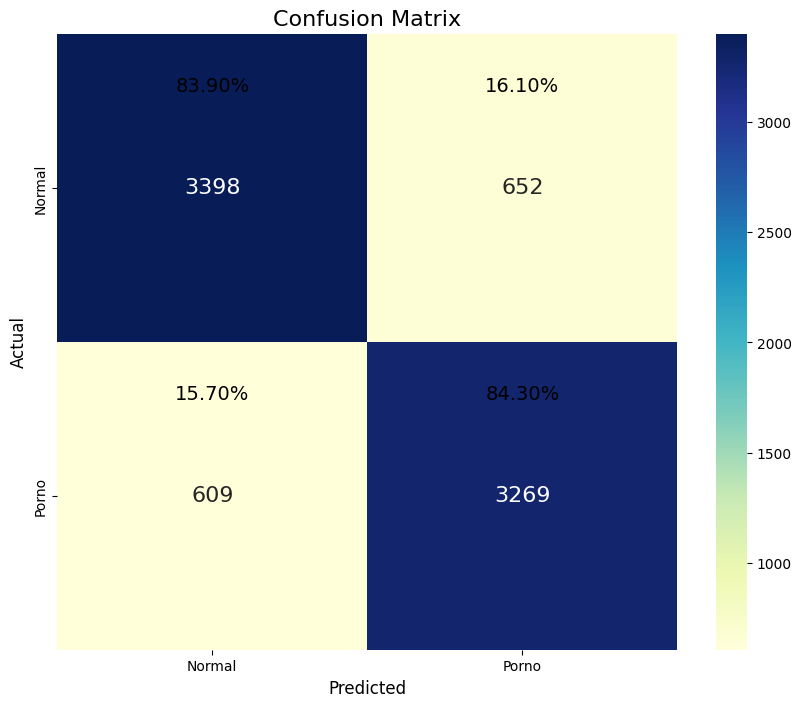

In [37]:
y_pred_classes = (yprednudenet > 0.5).astype(int)
y_true_classes = nudenet_test_generator.classes

cm = confusion_matrix(y_true_classes, y_pred_classes)


# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", cr)

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [73]:
from tensorflow.keras.models import load_model

In [78]:
model=load_model(r'A:\AI DB\LSPD\models\inceptionv3_lspd.keras')

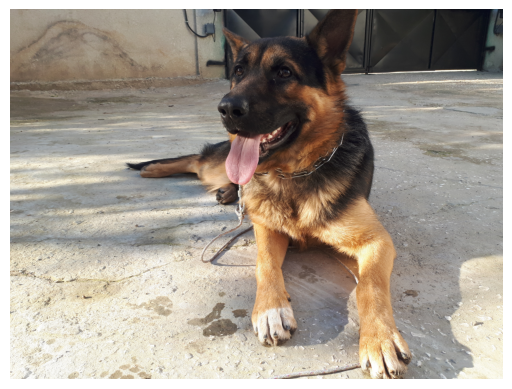

1/1 [==============================] - 0s 125ms/step
model la5er :
0.0000104376
normal

model wahda5or :
1/1 [==============================] - 0s 19ms/step
['0.0000627017', '0.0000062324', '0.9983635545', '0.0014981830', '0.0000693331']


In [89]:
imagepath=r'E:\kolech\ali\Ali photos\20180215_163639.jpg'
image = cv2.imread(imagepath)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()
a=combined_model.predict(preprocess_frame(imagepath))
print("model la5er :")
print("{:.10f}".format(a[0, 0]))
if a >0.5 :
    print("Porno")
else :
    print("normal")

print()
print("model wahda5or :")
a=model.predict(preprocess_frame(imagepath))
# Format each element to avoid scientific notation
formatted_arr = [[f"{num:.10f}" for num in sublist] for sublist in a]

# Print the formatted array
for sublist in formatted_arr:
    print(sublist)
#if a >0.5 :
#    print("Porno")
#else :
#    print("normal")

In [41]:
def preprocess_frame(path):
    frame=cv2.imread(path)
    # Resize the frame to 224x224
    resized_frame = cv2.resize(frame, (224, 224))
    # Convert the frame to RGB (if it's in BGR)
    if resized_frame.shape[2] == 3:
        resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # Convert the frame to a format suitable for MobileNetV2
    processed_frame = resized_frame / 255.0
    # Add batch dimension
    processed_frame = np.expand_dims(processed_frame, axis=0)
    return processed_frame